In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import pickle
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
from torchsummary import summary
from PIL import Image
from torch.optim.lr_scheduler import StepLR

In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input/'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/deep-learning-spring-2025-project-1/cifar_test_nolabel.pkl
/kaggle/input/deep-learning-spring-2025-project-1/cifar-10-python/cifar-10-batches-py/data_batch_1
/kaggle/input/deep-learning-spring-2025-project-1/cifar-10-python/cifar-10-batches-py/data_batch_2
/kaggle/input/deep-learning-spring-2025-project-1/cifar-10-python/cifar-10-batches-py/batches.meta
/kaggle/input/deep-learning-spring-2025-project-1/cifar-10-python/cifar-10-batches-py/test_batch
/kaggle/input/deep-learning-spring-2025-project-1/cifar-10-python/cifar-10-batches-py/data_batch_3
/kaggle/input/deep-learning-spring-2025-project-1/cifar-10-python/cifar-10-batches-py/data_batch_5
/kaggle/input/deep-learning-spring-2025-project-1/cifar-10-python/cifar-10-batches-py/data_batch_4
/kaggle/input/deep-learning-spring-2025-project-1/cifar-10-python/cifar-10-batches-py/readme.html


In [15]:
def load_cifar_batch(file):
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

# Specify the folder where the CIFAR-10 batch files are
cifar10_dir = '/kaggle/input/deep-learning-spring-2025-project-1/cifar-10-python/cifar-10-batches-py'

# Load the label names
meta_data_dict = load_cifar_batch(os.path.join(cifar10_dir, 'batches.meta'))
label_names = meta_data_dict[b'label_names']

train_images = []
train_labels = []
data_batches = ['data_batch_1', 'data_batch_2', 'data_batch_3', 'data_batch_4', 'data_batch_5']
for batch in data_batches:
    # Load one batch for demonstration (e.g., data_batch_1)
    batch_dict = load_cifar_batch(os.path.join(cifar10_dir, batch))
    train_images.append(batch_dict[b'data'])
    train_labels.append(batch_dict[b'labels'])

train_images = np.concatenate((train_images[0], train_images[1], train_images[2], train_images[3], train_images[4]))
train_labels = np.concatenate((train_labels[0], train_labels[1], train_labels[2], train_labels[3], train_labels[4]))

# Reshape the images
train_images = train_images.reshape((50000, 3, 32, 32)).transpose(0, 2, 3, 1)

def load_cifar_batch(file):
    with open(file, 'rb') as fo:
        batch = pickle.load(fo, encoding='bytes')
    return batch

# Load the batch
cifar10_batch = load_cifar_batch('/kaggle/input/deep-learning-spring-2025-project-1/cifar_test_nolabel.pkl')

# Extract images 
test_images = cifar10_batch[b'data']

# test_images = test_images.reshape((10000, 3, 32, 32)).transpose(0, 2, 3, 1)

validation_data = load_cifar_batch('/kaggle/input/deep-learning-spring-2025-project-1/cifar-10-python/cifar-10-batches-py/test_batch')

validation_images = validation_data[b'data']
validation_labels = validation_data[b'labels']

validation_images = validation_images.reshape((10000, 3, 32, 32)).transpose(0, 2, 3, 1)

# train_transform = transforms.Compose([
#     transforms.RandomCrop(32, padding=4),  # Randomly crop the image
#     transforms.RandomHorizontalFlip(),      # Randomly flip the image horizontally
#     transforms.RandomRotation(10),          # Randomly rotate the image by 10 degrees
#     transforms.ToTensor(),                  # Convert image to Tensor
#     transforms.Normalize(mean=[0.4914, 0.4822, 0.4465], std=[0.247, 0.243, 0.261])
# ])

# test_transform = transforms.Compose([
#     transforms.ToTensor(),
#     transforms.Normalize(mean=[0.4914, 0.4822, 0.4465], std=[0.247, 0.243, 0.261])
# ])

train_dataset = [(img, label) for img, label in zip(train_images, train_labels)]
validation_dataset = [(img, label) for img, label in zip(validation_images, validation_labels)]
# test_dataset = [(img) for img in test_images]

trainDataLoader = torch.utils.data.DataLoader(train_dataset,batch_size=64,shuffle=True)

validationDataLoader = torch.utils.data.DataLoader(validation_dataset,batch_size=64,shuffle=False)

testDataLoader = torch.utils.data.DataLoader(test_images,batch_size=64,shuffle=False)

In [16]:
class BuildingBlock(nn.Module):

    
    def __init__(self, in_planes, planes, stride=1):
        super(BuildingBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.relu1 = nn.ReLU()
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.relu2 = nn.ReLU()

        self.skip = nn.Sequential()
        if stride != 1 or in_planes != planes:
            self.skip = nn.Sequential(
                nn.Conv2d(in_planes, planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes)
            )
        self.dropout = nn.Dropout(0.2)

    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu1(out)
        out = self.conv2(out)
        out = self.bn2(out)  
        out += self.skip(x) 
        out = self.relu2(out)
        out = self.dropout(out)
        return out


class ResNet(nn.Module):
    
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 64
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        # self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(256, num_classes)


    def _make_layer(self, block, planes, num_blocks, stride):
        layers = [block(self.in_planes, planes, stride)]
        self.in_planes = planes  # Update input channels
        for _ in range(1, num_blocks):
            layers.append(block(self.in_planes, planes, stride=1))
        return nn.Sequential(*layers)


    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        # out = self.layer4(out)
        out = F.avg_pool2d(out, 8)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

In [17]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model = ResNet(BuildingBlock, [3, 3, 3])
model = model.to(device)
summary(model, (3, 32, 32))

from tqdm import tqdm

loss = torch.nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
scheduler = StepLR(optimizer, step_size=30, gamma=0.1)

train_loss_history = []
test_loss_history = []

num_epochs = 100

for epoch in tqdm(range(num_epochs)):
  train_loss = 0.0
  test_loss = 0.0

  correct = 0
  total = 0
  model.train()
  for i, data in enumerate(trainDataLoader):
    images, labels = data
    images = images.to(device)
    images = torch.tensor(images, dtype=torch.float32)  # Convert NumPy array to PyTorch tensor
    images = images.permute(0, 3, 1, 2)
    labels = labels.to(device)
    optimizer.zero_grad() # zero out any gradient values from the previous iteration
    predicted_output = model(images) # forward propagation
    predicted = torch.argmax(predicted_output, dim=1)
    correct += (predicted == labels).sum().item()  # Count correct predictions
    total += labels.size(0)  # Total number of samples
    fit = loss(predicted_output, labels)  # calculate our measure of goodness
    fit.backward() # backpropagation
    optimizer.step() # update the weights of our trainable parameters
    train_loss += fit.item()

  accuracy = 100 * correct / total  # Compute accuracy percentage
  print(f'Train Accuracy: {accuracy:.2f}%')

  correct = 0
  total = 0
  model.eval()
  for i, data in enumerate(validationDataLoader):
    with torch.no_grad():
      images, labels = data
      images = images.to(device)
      images = torch.tensor(images, dtype=torch.float32)  # Convert NumPy array to PyTorch tensor
      images = images.permute(0, 3, 1, 2)
      labels = labels.to(device)
      predicted_output = model(images)
      predicted = torch.argmax(predicted_output, dim=1)
      correct += (predicted == labels).sum().item()  # Count correct predictions
      total += labels.size(0)  # Total number of samples
      fit = loss(predicted_output, labels)
      test_loss += fit.item()
  train_loss = train_loss / len(trainDataLoader)
  test_loss = test_loss / len(testDataLoader)
  train_loss_history += [train_loss]
  test_loss_history += [test_loss]
  accuracy = 100 * correct / total  # Compute accuracy percentage
  print(f'Test Accuracy: {accuracy:.2f}%')
  print(f'Epoch {epoch}, Train loss {train_loss}, Test loss {test_loss}')

  scheduler.step()

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
            Conv2d-3           [-1, 64, 32, 32]          36,864
       BatchNorm2d-4           [-1, 64, 32, 32]             128
              ReLU-5           [-1, 64, 32, 32]               0
            Conv2d-6           [-1, 64, 32, 32]          36,864
       BatchNorm2d-7           [-1, 64, 32, 32]             128
              ReLU-8           [-1, 64, 32, 32]               0
           Dropout-9           [-1, 64, 32, 32]               0
    BuildingBlock-10           [-1, 64, 32, 32]               0
           Conv2d-11           [-1, 64, 32, 32]          36,864
      BatchNorm2d-12           [-1, 64, 32, 32]             128
             ReLU-13           [-1, 64, 32, 32]               0
           Conv2d-14           [-1, 64,

  0%|          | 0/100 [00:00<?, ?it/s]<ipython-input-17-b7dc0f5ddc44>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  images = torch.tensor(images, dtype=torch.float32)  # Convert NumPy array to PyTorch tensor
  0%|          | 0/100 [00:06<?, ?it/s]


KeyboardInterrupt: 

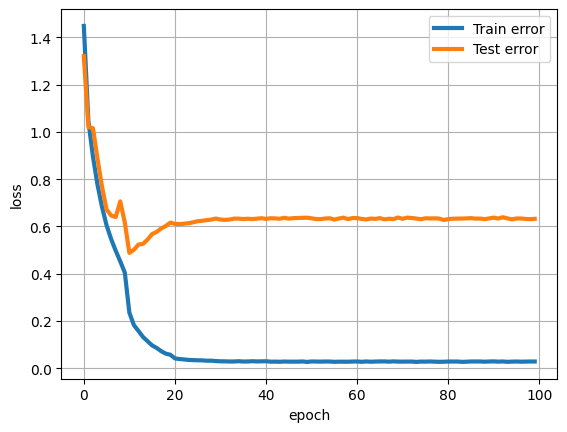

In [6]:
plt.plot(range(num_epochs),train_loss_history,'-',linewidth=3,label='Train error')
plt.plot(range(num_epochs),test_loss_history,'-',linewidth=3,label='Test error')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.grid(True)
plt.legend()
plt.show()

In [7]:
model.eval()
predictions = []
with torch.no_grad():
    for images in testDataLoader:
        images = images.to(device)
        images = torch.tensor(images, dtype=torch.float32)  # Convert NumPy array to PyTorch tensor
        images = images.permute(0, 3, 1, 2)
        outputs = model(images)
        predicted = torch.argmax(outputs, dim=1)
        predictions.extend(predicted.cpu().numpy())

submission = pd.DataFrame({'ID': np.arange(len(predictions)), 'Labels': predictions})
submission.to_csv('/kaggle/working/submission.csv', index=False)
print("Submission file saved.")

<ipython-input-7-6a64002b8820>:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  images = torch.tensor(images, dtype=torch.float32)  # Convert NumPy array to PyTorch tensor


Submission file saved.


In [8]:
torch.save(model.state_dict(), "model_weights.pth")